Data Info.:

Takehome_users.csv: Data on 12,000 users who signed up for the product in the last two years
- name: the user's name
- object_id: the user's id
- email: email address
- creation_source: how their account was created. This takes on one
of 5 values:
    - PERSONAL_PROJECTS: invited to join another user's personal workspace
    - GUEST_INVITE: invited to an organization as a guest (limited permissions)
    - ORG_INVITE: invited to an organization (as a full member)
    - SIGNUP: signed up via the website
    - SIGNUP_GOOGLE_AUTH: signed up using Google
Authentication (using a Google email account for their login
id)
- creation_time: when they created their account
- last_session_creation_time: unix timestamp of last login
- opted_in_to_mailing_list: whether they have opted into receiving
marketing emails
- enabled_for_marketing_drip: whether they are on the regular
marketing email drip
- org_id: the organization (group of users) they belong to
- invited_by_user_id: which user invited them to join (if applicable).

Takehome_user_engagement.csv: Data of a row for each day that a user logged into the product

- An "adopted user" is a user who has logged into the product on three separate days in at least one seven-day period, identify which factors predict future user adoption



GOAL: Identify which factors predict future user adoption

In [258]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [287]:
# Reads csv files and creates dataframes

users = pd.read_csv('takehome_users.csv', encoding = 'ISO-8859-1')
logins = pd.read_csv('takehome_user_engagement.csv')

In [288]:
users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN


In [268]:
logins

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
...,...,...,...
207912,2013-09-06 06:14:15,11996,1
207913,2013-01-15 18:28:37,11997,1
207914,2014-04-27 12:45:16,11998,1
207915,2012-06-02 11:55:59,11999,1


In [289]:
# Prints info. on both users and logins data

print('Users Data:\n')
users.info()
print('\nLogins Data:\n')
logins.info()

Users Data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB

Logins Data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   

# Data Wrangling

In [290]:
# Gets list of users to have login data since there are null values in 'last_session_creation_time' 

print('Users with login data: ', len(logins.loc[:,'user_id'].unique()))

Users with login data:  8823


In [291]:
# Deletes data of users with no login data, as missing data would deprive us of knowing whether those users could have been 'adopted users' or not 
# and thus will not be a useful set of data to use to determine what factors are useful in creating 'adopted users'

users = users[users['last_session_creation_time'].notna()]
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   8823 non-null   int64  
 1   creation_time               8823 non-null   object 
 2   name                        8823 non-null   object 
 3   email                       8823 non-null   object 
 4   creation_source             8823 non-null   object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    8823 non-null   int64  
 7   enabled_for_marketing_drip  8823 non-null   int64  
 8   org_id                      8823 non-null   int64  
 9   invited_by_user_id          4776 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 758.2+ KB


In [273]:
# Gets list of adopted users

adopted_users = []

for user in tqdm(logins.loc[:,'user_id'].unique()):
    l2 = logins.copy()
    l2 = l2.loc[l2['user_id'] == user]

    # Removes duplicates dates and sorts
    l2['time_stamp'] = pd.to_datetime(logins['time_stamp'], format='%Y%m%d %H:%M:%S')
    l2['dates'] = l2['time_stamp'].dt.date
    l2 = l2.drop_duplicates(subset = 'dates')

    # Sorts by dates
    l2 = l2.sort_values('dates')

    # Checks the delta in days between every 3 chronological logins
    delta_days = l2['time_stamp'].diff(periods = 2)

    # Checks if any of delta in days is within 7 days
    result = any(delta_days <= pd.to_timedelta('7 days 0:00:00'))
    
    # Appends to list of adopted users if satisfies adoped_users conditions as determined by result status
    if result: adopted_users.append(user)
    
adopted_users

100%|██████████| 8823/8823 [05:42<00:00, 25.80it/s]


[2,
 10,
 20,
 33,
 42,
 43,
 50,
 53,
 60,
 63,
 69,
 74,
 80,
 81,
 82,
 87,
 133,
 135,
 141,
 146,
 153,
 160,
 165,
 168,
 172,
 174,
 185,
 188,
 197,
 200,
 202,
 203,
 209,
 214,
 230,
 245,
 247,
 263,
 265,
 275,
 280,
 283,
 297,
 298,
 305,
 310,
 311,
 321,
 322,
 341,
 345,
 347,
 351,
 362,
 363,
 370,
 383,
 397,
 401,
 418,
 430,
 445,
 450,
 460,
 462,
 469,
 471,
 472,
 478,
 479,
 483,
 492,
 494,
 497,
 502,
 506,
 509,
 510,
 512,
 518,
 520,
 522,
 529,
 535,
 540,
 547,
 553,
 564,
 572,
 589,
 591,
 601,
 603,
 605,
 618,
 627,
 628,
 632,
 634,
 639,
 669,
 679,
 680,
 717,
 724,
 725,
 728,
 754,
 772,
 783,
 786,
 804,
 828,
 845,
 851,
 869,
 874,
 882,
 885,
 901,
 906,
 907,
 912,
 928,
 932,
 934,
 937,
 943,
 953,
 980,
 985,
 1007,
 1009,
 1013,
 1017,
 1018,
 1026,
 1027,
 1035,
 1039,
 1055,
 1061,
 1072,
 1089,
 1093,
 1094,
 1099,
 1106,
 1107,
 1119,
 1123,
 1124,
 1128,
 1129,
 1136,
 1145,
 1150,
 1151,
 1155,
 1156,
 1163,
 1173,
 1186,
 1196,


In [202]:
print('There are', len(adopted_users), 'adopted users')

There are 1656 adopted users


In [297]:
# Creates adopted users column for users data

users['adopted user'] = 0

for index, row in tqdm(users.iterrows()):
    if any(row.loc['object_id'] == user for user in adopted_users): 
        users.loc[index,'adopted user'] = 1

users
users['adopted user'].value_counts()

<ipython-input-297-c8bc0c4d8a73>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users['adopted user'] = 0
0it [00:00, ?it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
8823it [01:41, 86.91it/s] 


0    7167
1    1656
Name: adopted user, dtype: int64

In [298]:
# Creates column of email services as it might be a useful factor in prediction of adopted users

users['email domain'] = users['email'].str.split('@').str[1]

<ipython-input-298-70a06b6b3c82>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users['email domain'] = users['email'].str.split('@').str[1]


In [299]:
# Creates column 'active_time' calculating the period of time in days from account creation to last login, since it might be a useful factor in prediction of adopted users

# Converts 'creation_time' to datetime
users['creation_time'] = pd.to_datetime(users['creation_time'])

# Converts 'last_session_creation_time' to datetime
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')

# Creates new column of active time in days
users['active time'] = users['last_session_creation_time'] - users['creation_time']
users['active time'] = users['active time'].dt.days

users

<ipython-input-299-21f8b40c167f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users['creation_time'] = pd.to_datetime(users['creation_time'])
<ipython-input-299-21f8b40c167f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')
<ipython-input-299-21f8b40c167f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,email domain,active time,adopted user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,yahoo.com,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,gustr.com,136,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,gustr.com,0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,yahoo.com,1,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,yahoo.com,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,2013-09-06 06:14:15,0,0,89,8263.0,gustr.com,0,0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,2013-01-15 18:28:37,0,0,200,NaN,gmail.com,5,0
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,2014-04-27 12:45:16,1,1,83,8074.0,cuvox.de,0,0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,2012-06-02 11:55:59,0,0,6,NaN,iuxiw.com,2,0


# EDA

In [300]:
# Examines 'invited_by_user_id' since there are null values

users.loc[:,'invited_by_user_id'].value_counts()

4612.0     10
11770.0     9
2308.0      9
1525.0      8
6808.0      8
           ..
3689.0      1
8847.0      1
11961.0     1
743.0       1
1600.0      1
Name: invited_by_user_id, Length: 2229, dtype: int64

'invited_by_user_id' will probably not be a useful factor in determining an adopted user, given the myriad number of users sending invites with the most being 10 to an overall group of 8823

In [301]:
# Examines 'org_id' to determine usefulness

users.loc[:,'org_id'].value_counts()

0      228
1      172
2      150
3      125
4      122
      ... 
322      6
400      6
397      5
386      4
416      2
Name: org_id, Length: 417, dtype: int64

'org_id' will probably not be very useful in determining an adopted user, given the myriad number of organizations with the most having 228 users in an overall group for 8823 total users

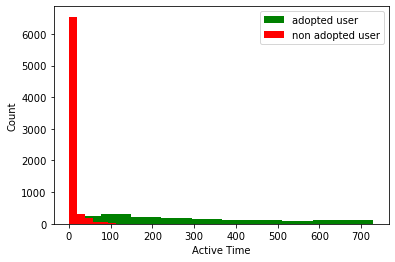

In [302]:
# Displays plot of count of active time vs. count of adopted & non adopted users  

_ = plt.hist(users.loc[users['adopted user']==1, 'active time'], color='g', label='adopted user')
_ = plt.hist(users.loc[users['adopted user']==0, 'active time'], color='r', label='non adopted user')
plt.xlabel('Active Time')
plt.ylabel('Count') 
plt.legend()

Adopted users were more likely to have more active time in days, and thus 'active time' would be a useful indicator in determining adopted user status.

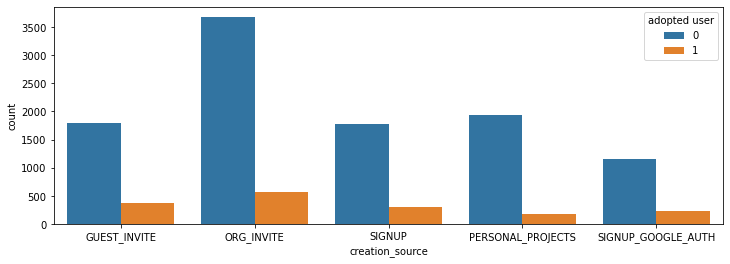

In [245]:
# Displays the creation source vs. count of adopted & non adopted users

plt.figure(figsize=(12,4))
_ = sns.countplot(x='creation_source', data=users, hue='adopted user')

In [220]:
# Calculates proportion of creation source for adopted users & non adopted users

users.groupby('creation_source')['adopted user'].apply(lambda x: sum(x)/len(x))

creation_source
GUEST_INVITE          0.170596
ORG_INVITE            0.134932
PERSONAL_PROJECTS     0.081478
SIGNUP                0.144705
SIGNUP_GOOGLE_AUTH    0.172563
Name: adopted user, dtype: float64

Signup by google_auth (17.25%) and guest_invite (17.1%) were the more indicative factors of whether the users would be an adopted users. This might be a useful factor in determining adopted user status.

In [317]:
# Calculates proportion of email providers for adopted users

email_adopted = users.groupby('email domain')['adopted user'].apply(lambda x: sum(x)/len(x)) 
print(email_adopted.nlargest(5))
print('Length: ', len(email_adopted))

email domain
amknl.com    1.0
anmvu.com    1.0
aosyq.com    1.0
bawmq.com    1.0
bgdtm.com    1.0
Name: adopted user, dtype: float64
Length:  812


Out of the 812 email domains, the five largest email domains had a max of 1 adopted user. Thus, this would not be a helpful factor in determining who would become an adopted user.

In [232]:
# Calculates proportion of adopted users grouped by who did and did not opt in to mailing list

users.groupby('opted_in_to_mailing_list')['adopted user'].apply(lambda x: sum(x)/len(x))

opted_in_to_mailing_list
0    0.136243
1    0.143287
Name: adopted user, dtype: float64

About 13.6% and 14.3% of users who did not and did opt into mailing lists were adopted users. There is a negligible relationship in those opting in or out of the mailing list and adopted users.

In [231]:
# Calculates proportion of adopted users grouped by who did and did not enable for marketing drip

users.groupby('enabled_for_marketing_drip')['adopted user'].apply(lambda x: sum(x)/len(x))

enabled_for_marketing_drip
0    0.137049
1    0.143415
Name: adopted user, dtype: float64

About 13.7% and 14.3% of users who did not and did opt enable for marketing drip were adopted users respectively. There is a negligible relationship in those opting in or out of the mailing list and adopted users.

# Pre-Processing

In [319]:
# Does one hot encoding for 'creation_source' feature

c_source = pd.get_dummies(users['creation_source'], prefix = 'c_source')
users = users.merge(c_source, left_index = True, right_index = True)

In [321]:
users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,email domain,active time,adopted user,c_source_GUEST_INVITE,c_source_ORG_INVITE,c_source_PERSONAL_PROJECTS,c_source_SIGNUP,c_source_SIGNUP_GOOGLE_AUTH
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,yahoo.com,0,0,1,0,0,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,gustr.com,136,1,0,1,0,0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,gustr.com,0,0,0,1,0,0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,yahoo.com,1,0,1,0,0,0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,yahoo.com,5,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,2013-09-06 06:14:15,0,0,89,8263.0,gustr.com,0,0,0,1,0,0,0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,2013-01-15 18:28:37,0,0,200,NaN,gmail.com,5,0,0,0,0,0,1
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,2014-04-27 12:45:16,1,1,83,8074.0,cuvox.de,0,0,1,0,0,0,0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,2012-06-02 11:55:59,0,0,6,NaN,iuxiw.com,2,0,0,0,1,0,0


In [327]:
# Creates the training and testing sets for model prediction

data = users.copy()

X = data.drop(['adopted user', 'enabled_for_marketing_drip', 'opted_in_to_mailing_list', 'email domain', 'org_id', 'name', 'creation_source', 'last_session_creation_time', 'object_id', 'creation_time', 'name', 'email', 'invited_by_user_id'], axis=1)
y = data['adopted user']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

In [328]:
X

,active time,c_source_GUEST_INVITE,c_source_ORG_INVITE,c_source_PERSONAL_PROJECTS,c_source_SIGNUP,c_source_SIGNUP_GOOGLE_AUTH
0,0,1,0,0,0,0
1,136,0,1,0,0,0
2,0,0,1,0,0,0
3,1,1,0,0,0,0
4,5,1,0,0,0,0
...,...,...,...,...,...,...
11995,0,0,1,0,0,0
11996,5,0,0,0,0,1
11997,0,1,0,0,0,0
11998,2,0,0,1,0,0


# Modeling

In [331]:
# Creates a logistic regression model

# Grid searches to find best model and fits it
lr = LogisticRegression(random_state = 0, max_iter = 1000)
param_grid = {'C': [0.01,0.1,1]}
gs_lr = GridSearchCV(lr, param_grid = param_grid, scoring = 'accuracy', cv = 3, n_jobs = -1)
gs_lr.fit(X_train, y_train)
lr = gs_lr.best_estimator_

# Makes predictions
y_pred_lr = lr.predict(X_test)

In [332]:
# Gets the classification report

print(classification_report(y_test, y_pred_lr, zero_division = 0))
print(confusion_matrix(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1792
           1       0.93      0.87      0.90       414

    accuracy                           0.96      2206
   macro avg       0.95      0.93      0.94      2206
weighted avg       0.96      0.96      0.96      2206

[[1763   29]
 [  55  359]]


Active time and creation source seem to be important factors in determing whether the user will be an adopted user or not. A way to convert more users to adopted users might be to give perks to regular users of the site in order to incentivze them to stay longer and return more frequently. Another way is to increase marketing of the site through incentivizing more organizations to send out more invites to the site.